In [78]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from layout_getter import getLayout
plt.rcParams['font.sans-serif']=['SimHei'] # make sure Chinese can be displayed correctly
plt.rcParams['axes.unicode_minus']=False # make sure Chinese can be displayed correctly



def plotAsynchrony(data, ch_names, montage_kind):
    '''
    data: 1d numpy array (#channels,)
    ch_names: channel names from epoch info
    montage_kind: kind of montage
          Valid ``kind`` arguments are:

        ===================   =====================================================
        Kind                  Description
        ===================   =====================================================
        standard_1005         Electrodes are named and positioned according to the
                              international 10-05 system (343+3 locations)
        standard_1020         Electrodes are named and positioned according to the
                              international 10-20 system (94+3 locations)
        standard_alphabetic   Electrodes are named with LETTER-NUMBER combinations
                              (A1, B2, F4, ...) (65+3 locations)
        standard_postfixed    Electrodes are named according to the international
                              10-20 system using postfixes for intermediate
                              positions (100+3 locations)
        standard_prefixed     Electrodes are named according to the international
                              10-20 system using prefixes for intermediate
                              positions (74+3 locations)
        standard_primed       Electrodes are named according to the international
                              10-20 system using prime marks (' and '') for
                              intermediate positions (100+3 locations)

        biosemi16             BioSemi cap with 16 electrodes (16+3 locations)
        biosemi32             BioSemi cap with 32 electrodes (32+3 locations)
        biosemi64             BioSemi cap with 64 electrodes (64+3 locations)
        biosemi128            BioSemi cap with 128 electrodes (128+3 locations)
        biosemi160            BioSemi cap with 160 electrodes (160+3 locations)
        biosemi256            BioSemi cap with 256 electrodes (256+3 locations)

        easycap-M1            EasyCap with 10-05 electrode names (74 locations)
        easycap-M10           EasyCap with numbered electrodes (61 locations)

        EGI_256               Geodesic Sensor Net (256 locations)

        GSN-HydroCel-32       HydroCel Geodesic Sensor Net and Cz (33+3 locations)
        GSN-HydroCel-64_1.0   HydroCel Geodesic Sensor Net (64+3 locations)
        GSN-HydroCel-65_1.0   HydroCel Geodesic Sensor Net and Cz (65+3 locations)
        GSN-HydroCel-128      HydroCel Geodesic Sensor Net (128+3 locations)
        GSN-HydroCel-129      HydroCel Geodesic Sensor Net and Cz (129+3 locations)
        GSN-HydroCel-256      HydroCel Geodesic Sensor Net (256+3 locations)
        GSN-HydroCel-257      HydroCel Geodesic Sensor Net and Cz (257+3 locations)

        mgh60                 The (older) 60-channel cap used at
                              MGH (60+3 locations)
        mgh70                 The (newer) 70-channel BrainVision cap used at
                              MGH (70+3 locations)
        ===================   =====================================================

    '''
    
    # how smooth the plot should be
    N = 300
    
    
    # get the layout 
    layout = getLayout(montage_kind, ch_names)

    # add 4 corners
    layoutNew = layout[['name', 'x', 'y']].copy()
    top = max(layoutNew['x']) + 0.1
    bottom = min(layoutNew['x']) - 0.1
    left, right = bottom, top
    corners = pd.DataFrame([['corner1', left, top],['corner2', left, bottom],['corner3', right, top],['corner4', right, bottom]], columns= ['name', 'x', 'y'])
    layoutNew = layoutNew.append(corners)
    latoutNew  = layoutNew.reset_index()

    # calculate center and radius of topomap
    xy_center = [(layout['x'].max() + layout['x'].min())/2, (layout['y'].max() + layout['y'].min())/2]  
    radius = ((layout['x'].max() -  layout['x'].min())/2) + 0.6

    
    # append corner to data, data should be 1d array, length = #channels + 4
    data = np.append(data,[0,0,0,0])


    # mesh data 
    x,y = layoutNew['x'].tolist(), layoutNew['y'].tolist()
    xi = np.linspace(-2.8,2.8,N)
    yi = np.linspace(-2.8,2.8,N)
    zi = griddata((x, y), 10**6 * data, (xi[None,:], yi[:,None]), method='cubic')

    # add a circle mask, so that anything outside the mask will not be seen
    for i in range(N):
        for j in range(N):
            r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
            if r > radius - 0.49:
                zi[i,j] = "nan"


    fig, ax = plt.subplots()
    fig.set_size_inches(4,4) # set the figure size
    # grey contour lines
    CS = ax.contour(xi, yi, zi, colors = "grey", alpha = 0.5, zorder = 2, linestyles='solid')
    # filled contour plot 
    CSF = ax.contourf(xi, yi, zi, 60, cmap='Spectral', zorder = 1)


    # add a circle representing head
    circle = patches.Circle(xy = [0.5 * t for t  in xy_center], radius = radius-0.5, edgecolor = "k", facecolor = "none", linewidth = 2.2)
    ax.add_patch(circle)
    # draw a nose
    points = [(xy_center[0]-(radius-0.5)/5, xy_center[1]+radius-0.5), (xy_center[0], xy_center[1]+radius), (xy_center[0]+(radius-0.5)/5, xy_center[1]+radius-0.5)]
    line = plt.Polygon(points, closed=None, fill=None, edgecolor = "k", facecolor = "none",linewidth = 2.2)
    ax.add_patch(line)
    

    # hide the borders of ax
    ax.set_axis_off()

    # add a colorbar
    vmax, vmin = np.nanmax(zi), np.nanmin(zi) # the max and min value of contour plot 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position = "right", size = "5%", pad = 0.05)
    cbar = plt.colorbar(CSF, cax=cax, ticks = [vmax, 0, vmin])
    cbar.ax.set_yticklabels(['before %.3f ms'%(vmin), '0', 'after %.3f ms' %(vmax)])
    
    ax.set_title("Channel Asynchrony Plot")
    
    return fig,ax 

In [79]:
data = ep.average().data[:,0]

(<Figure size 288x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17b6589ac88>)

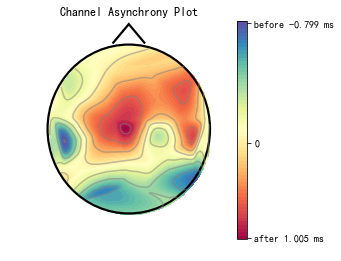

In [80]:

plotAsynchrony(data,ch_names=ep.ch_names, montage_kind = 'standard_1005')